In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
from subprocess import check_output
import seaborn as sns
from matplotlib import interactive
interactive(True)


In [2]:
#récupération de la data au format csv
data = pd.read_csv("var/match_stats.csv")
data_time = pd.read_csv("var/match_stats_time.csv")
#récupération de la data au format sql
bdd = sqlite3.connect('var/data.db')
curseur = bdd.cursor()
#requête pour récupérer les games avec toutes les features
curseur.execute('select * from match_stats')
matchs=[]

for match in curseur.fetchall():
    matchs.append(match)

#Execution avec toutes les features 
#curseur.execute('select t1_first_blood,t1_first_tower,t1_first_inhibitor,t1_first_baron,t1_first_dragon,t1_first_rift_herald,t1_tower,t2_tower,t1_inhibitor,t2_inhibitor,t1_baron,t2_baron,t1_dragon,t2_dragon,t1_kills,t2_kills,t1_minions,t2_minions,t1_gold_earned,t2_gold_earned from match_stats limit 10000')
#Execution de la requête avec les 5 meilleures features en moins
#curseur.execute('select t1_first_blood,t1_first_tower,t1_first_inhibitor,t1_first_baron,t1_first_dragon,t1_first_rift_herald,t2_tower,t2_inhibitor,t2_baron,t1_dragon,t2_dragon,t2_kills,t1_minions,t2_minions,t2_gold_earned from match_stats limit 5000')
#Execution de la requête avec les 5 pires features en moins
curseur.execute('select t1_first_inhibitor,t1_first_baron,t1_tower,t2_tower,t1_inhibitor,t2_inhibitor,t1_baron,t2_baron,t1_dragon,t2_dragon,t1_kills,t2_kills,t2_minions,t1_gold_earned,t2_gold_earned from match_stats limit 1000')
matchs_bis=[]
for match_bis in curseur.fetchall():
    matchs_bis.append(match_bis)    
    
#Execution requête à partir de la table avec le temps
curseur.execute('select total_gold_25_t1,total_gold_25_t2,total_minions_25_t1,total_minions_25_t2,total_xp_25_t1,total_xp_25_t2 from match_stats_time limit 1500')
matchs_bis_time=[]
for match_bis_time in curseur.fetchall():
    matchs_bis_time.append(match_bis_time)  
    
#requête pour récupérer uniquement le résultat de la game    
curseur.execute('select t1_win from match_stats')    
t1_wins=[]
for t1_win in curseur.fetchall():
    tmp=str(t1_win)
    tmp=tmp[1:2]
    t1_wins.append(tmp)
    
#requête pour récupérer uniquement le résultat de la game à un temps donné   
curseur.execute('select t1_win from match_stats_time')    
t1_wins_time=[]
for t1_win_time in curseur.fetchall():
    tmp=str(t1_win_time)
    tmp=tmp[1:2]
    t1_wins_time.append(tmp)
    
bdd.close

<function Connection.close>

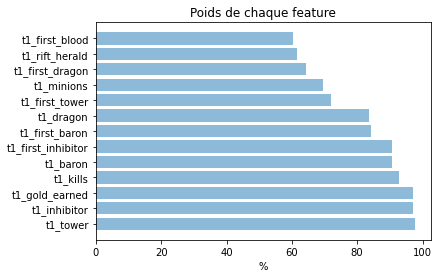

In [3]:
tmp_win = []
tmp = []
resultat = []

#Boucle qui récupére le pourcentage de game win par l'équipe qui a fait les first_blood,first_tower etc...
for i in [1,3,5,7,9,11]:
    for element in matchs:
        if element[i]==1:
             tmp.append(element[i])
             if element[27]==1:   
                 tmp_win.append(element[27])
    resultat.append(len(tmp_win)/len(tmp)*100)
    tmp_win = []
    tmp = []
    
#Boucle qui récupére le pourcentage de game win par l'équipe qui a fait le plus de kill, de minions etc...
for i in [13,15,17,19,21,23,25]:
    for element in matchs:
        if element[i]>element[i+1]:
             tmp.append(element[i])
             if element[27]==1:   
                 tmp_win.append(element[27])
    resultat.append(len(tmp_win)/len(tmp)*100)
    tmp_win = []
    tmp = []
   
objects = ('t1_tower', 't1_inhibitor', 't1_gold_earned', 't1_kills','t1_baron', 't1_first_inhibitor','t1_first_baron','t1_dragon','t1_first_tower','t1_minions','t1_first_dragon','t1_rift_herald','t1_first_blood')
y_pos = np.arange(len(objects))
resultat.sort(reverse=True)

plt.barh(y_pos, resultat, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('%')
plt.title('Poids de chaque feature')
plt.show()  

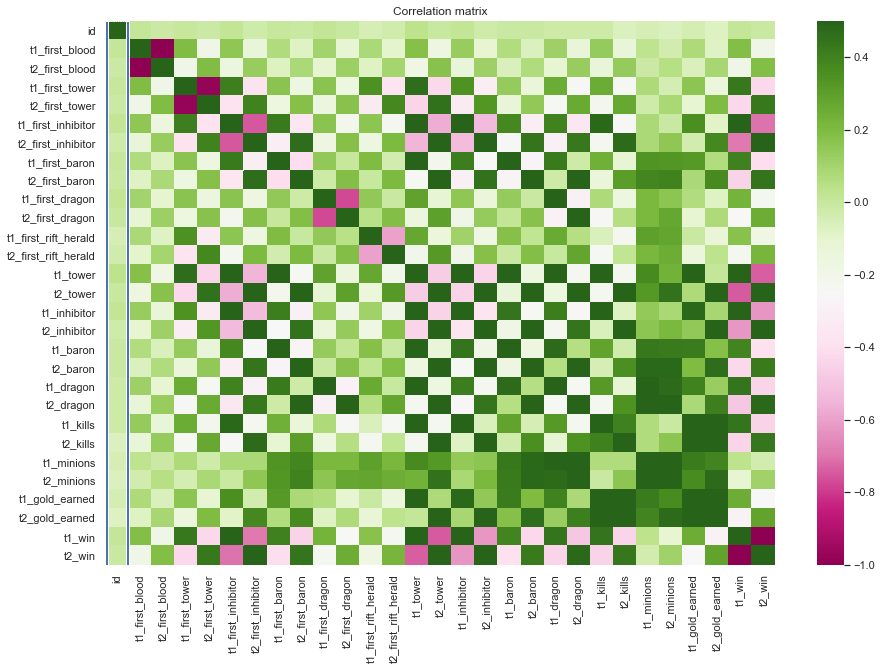

In [4]:
sns.set()
plt.figure(figsize=(15, 10))
plt.hist(data['t1_win'])
sns.heatmap(data.corr(), vmax=0.5, cmap="PiYG")
plt.title('Correlation matrix')
plt.show()

In [5]:
#split de la data dans x_train, x_test, y_train, y_test
#data = data.drop(['id'], axis=1)
#y = data['t2_win']
#x = data.drop(['t1_win','t2_win','t2_first_blood','t2_first_tower','t2_first_inhibitor','t2_first_baron','t2_first_dragon','t2_first_rift_herald','t1_first_blood','t1_first_rift_herald','t1_minions','t1_first_tower','t1_first_dragon'],axis=1)
#x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=0)


In [6]:
#split de la data dans x_train, x_test, y_train, y_test pour un temps donné du match
data_time = data_time.drop(['id'], axis=1)
y = data_time['t2_win']
x = data_time.loc[:, data_time.columns.intersection(['total_gold_25_t1','total_minions_25_t1','total_xp_25_t1','total_gold_25_t2','total_minions_25_t2','total_xp_25_t2'])]
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=0)


#recherche des meilleurs paramètres pour DecisionTreeClassifier
criterion=["gini","entropy"]
max_depth=range(1,20,2)
splitter=["best","random"]
dt=DecisionTreeClassifier()
grid_decision_tree=GridSearchCV(estimator=dt,cv=15,param_grid=dict(criterion=criterion,max_depth=max_depth,splitter=splitter))
grid_decision_tree.fit(x_train,y_train)
print("best score: ", grid_decision_tree.best_score_)
print("best param: ", grid_decision_tree.best_params_)

best score:  0.6862007168458781
best param:  {'criterion': 'entropy', 'max_depth': 7, 'splitter': 'random'}


In [7]:
#Test de la précision du modéle
dt2=DecisionTreeClassifier(criterion="entropy",max_depth=7, splitter="best")
dt2.fit(x_train,y_train)
print("train score:", dt2.score(x_train,y_train))
print("test score:", dt2.score(x_test,y_test))

train score: 0.7418655097613883
test score: 0.6883116883116883


In [8]:
clf = MLPClassifier(hidden_layer_sizes=(20,20,20),learning_rate_init = 0.01, max_iter=1000, alpha=0.1, solver='adam',tol=0.01,shuffle=True)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("train score:",clf.score(x_train, y_train))
print("test score:",clf.score(x_test, y_test))
print(confusion_matrix(y_test,y_pred))

train score: 0.702819956616052
test score: 0.7121212121212122
[[211  29]
 [104 118]]


In [9]:
#boucle pour prédire chaque game avec DecisionTreeClassifier
cpt=0
predict_algo_DecisionTreeClassifier = []
for element in matchs_bis_time:
    x1=[]
    x1.append(element)
    #On prédit l'issue de chaque game avec DecisionTreeClassifier
    c=dt2.predict_proba(x1).reshape(-1,1)
    if dt2.predict(x1) == 0:
        predict_algo_DecisionTreeClassifier.append("1")
    else:    
        predict_algo_DecisionTreeClassifier.append("0")
    #log    
    print("match n°",cpt," : ")
    print("winner is :" , dt2.predict(x1) )
    print("first team win probability is % ", list(c[0]*100),"\nsecond team win probability is %:",list(c[1]*100)  )
    cpt=cpt+1 

match n° 0  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 1  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 2  : 
winner is : [1]
first team win probability is %  [42.42424242424242] 
second team win probability is %: [57.57575757575758]
match n° 3  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 4  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 5  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 6  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 7  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win prob

first team win probability is %  [50.0] 
second team win probability is %: [50.0]
match n° 71  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 72  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 73  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 74  : 
winner is : [0]
first team win probability is %  [57.14285714285714] 
second team win probability is %: [42.857142857142854]
match n° 75  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 76  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 77  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 78  : 
winner is : [1]
first tea

first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 160  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 161  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 162  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 163  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 164  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 165  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 166  : 
winner is : [1]
first team win probability is %  [42.42424242424242] 
second team win probability is %: [57

first team win probability is %  [44.11764705882353] 
second team win probability is %: [55.88235294117647]
match n° 239  : 
winner is : [1]
first team win probability is %  [44.11764705882353] 
second team win probability is %: [55.88235294117647]
match n° 240  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 241  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 242  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 243  : 
winner is : [1]
first team win probability is %  [44.11764705882353] 
second team win probability is %: [55.88235294117647]
match n° 244  : 
winner is : [1]
first team win probability is %  [44.11764705882353] 
second team win probability is %: [55.88235294117647]
match n° 245  : 
winner is : [1]
first team win probability is %  [7.142

match n° 326  : 
winner is : [0]
first team win probability is %  [79.22077922077922] 
second team win probability is %: [20.77922077922078]
match n° 327  : 
winner is : [0]
first team win probability is %  [78.57142857142857] 
second team win probability is %: [21.428571428571427]
match n° 328  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 329  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 330  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 331  : 
winner is : [0]
first team win probability is %  [50.0] 
second team win probability is %: [50.0]
match n° 332  : 
winner is : [1]
first team win probability is %  [42.42424242424242] 
second team win probability is %: [57.57575757575758]
match n° 333  : 
winner is : [0]
first team win probability is %

first team win probability is %  [79.22077922077922] 
second team win probability is %: [20.77922077922078]
match n° 411  : 
winner is : [0]
first team win probability is %  [79.22077922077922] 
second team win probability is %: [20.77922077922078]
match n° 412  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 413  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 414  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 415  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 416  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 417  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team

first team win probability is %  [50.0] 
second team win probability is %: [50.0]
match n° 493  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 494  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 495  : 
winner is : [1]
first team win probability is %  [42.42424242424242] 
second team win probability is %: [57.57575757575758]
match n° 496  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 497  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 498  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 499  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 500  : 
winner is : [1]
first team win probability i

first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 578  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 579  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 580  : 
winner is : [1]
first team win probability is %  [42.42424242424242] 
second team win probability is %: [57.57575757575758]
match n° 581  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 582  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 583  : 
winner is : [0]
first team win probability is %  [79.22077922077922] 
second team win probability is %: [20.77922077922078]
match n° 584  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 585  : 
winner is : [1]
first team win probability i

match n° 662  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 663  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 664  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 665  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 666  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 667  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 668  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 669  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
seco

first team win probability is %  [44.11764705882353] 
second team win probability is %: [55.88235294117647]
match n° 749  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 750  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 751  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 752  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 753  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 754  : 
winner is : [0]
first team win probability is %  [50.0] 
second team win probability is %: [50.0]
match n° 755  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 756  : 
winner is : [0]
first team win probability i

second team win probability is %: [45.60747663551402]
match n° 834  : 
winner is : [0]
first team win probability is %  [84.61538461538461] 
second team win probability is %: [15.384615384615385]
match n° 835  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 836  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 837  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 838  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 839  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 840  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 841  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
s

match n° 915  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 916  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 917  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 918  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 919  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 920  : 
winner is : [1]
first team win probability is %  [33.33333333333333] 
second team win probability is %: [66.66666666666666]
match n° 921  : 
winner is : [0]
first team win probability is %  [79.22077922077922] 
second team win probability is %: [20.77922077922078]
match n° 922  : 
winner is : [0]
first team win probability is %  [57.14285714285714] 
seco

second team win probability is %: [45.60747663551402]
match n° 1004  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1005  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1006  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 1007  : 
winner is : [0]
first team win probability is %  [50.0] 
second team win probability is %: [50.0]
match n° 1008  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1009  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 1010  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 1011  : 
winner is : [0]
first team win probability is %  [100.0] 
second

first team win probability is %  [50.0] 
second team win probability is %: [50.0]
match n° 1087  : 
winner is : [1]
first team win probability is %  [7.142857142857142] 
second team win probability is %: [92.85714285714286]
match n° 1088  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1089  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 1090  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 1091  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 1092  : 
winner is : [1]
first team win probability is %  [7.142857142857142] 
second team win probability is %: [92.85714285714286]
match n° 1093  : 
winner is : [0]
first team win probability is %  [66.66666666666666] 
seco

match n° 1169  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 1170  : 
winner is : [0]
first team win probability is %  [50.0] 
second team win probability is %: [50.0]
match n° 1171  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1172  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 1173  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1174  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1175  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 1176  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.6074766355

winner is : [0]
first team win probability is %  [84.61538461538461] 
second team win probability is %: [15.384615384615385]
match n° 1251  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1252  : 
winner is : [0]
first team win probability is %  [79.22077922077922] 
second team win probability is %: [20.77922077922078]
match n° 1253  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1254  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1255  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 1256  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 1257  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probabili

first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 1342  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 1343  : 
winner is : [0]
first team win probability is %  [57.14285714285714] 
second team win probability is %: [42.857142857142854]
match n° 1344  : 
winner is : [1]
first team win probability is %  [7.142857142857142] 
second team win probability is %: [92.85714285714286]
match n° 1345  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 1346  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 1347  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1348  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
sec

match n° 1428  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1429  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1430  : 
winner is : [0]
first team win probability is %  [79.22077922077922] 
second team win probability is %: [20.77922077922078]
match n° 1431  : 
winner is : [1]
first team win probability is %  [44.11764705882353] 
second team win probability is %: [55.88235294117647]
match n° 1432  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [0.0]
match n° 1433  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 1434  : 
winner is : [0]
first team win probability is %  [54.39252336448598] 
second team win probability is %: [45.60747663551402]
match n° 1435  : 
winner is : [1]
first team win probability is %  [44.1176470588235

In [10]:
#boucle pour prédire chaque game avec MLPClassifier
cpt=0
predict_algo_MLPClassifier = []
for element in matchs_bis_time:
    x1=[]
    x1.append(element)
    #On prédit l'issue de chaque game avec MLPClassifier
    c=clf.predict_proba(x1).reshape(-1,1)
    if clf.predict(x1) == 0:
        predict_algo_MLPClassifier.append("1")
    else:    
        predict_algo_MLPClassifier.append("0")
    #log    
    print("match n°",cpt," : ")
    print("winner is :" , clf.predict(x1) )
    print("first team win probability is % ", list(c[0]*100),"\nsecond team win probability is %:",list(c[1]*100)  )
    cpt=cpt+1 

match n° 0  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [3.4124345866939927e-56]
match n° 1  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [5.0072382490373984e-57]
match n° 2  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [4.3894307119095094e-23]
match n° 3  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 4  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 5  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 6  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 7  : 
winner is : [0]
first team win probability is %  [53.308

winner is : [0]
first team win probability is %  [99.99989770478118] 
second team win probability is %: [0.00010229521883211232]
match n° 69  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [2.682684498570854e-18]
match n° 70  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [1.9717181960503675e-46]
match n° 71  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 72  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 73  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 74  : 
winner is : [1]
first team win probability is %  [0.0015939600816694544] 
second team win probability is %: [99.99840603991834]
match n° 75  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second

match n° 135  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 136  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 137  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 138  : 
winner is : [0]
first team win probability is %  [72.2719710739472] 
second team win probability is %: [27.72802892605279]
match n° 139  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 140  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 141  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 142  : 
winner is : [0]
fi

winner is : [0]
first team win probability is %  [99.9999993229238] 
second team win probability is %: [6.770761898168323e-07]
match n° 200  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 201  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [1.803917695659626e-26]
match n° 202  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 203  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 204  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 205  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 206  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100

first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 273  : 
winner is : [0]
first team win probability is %  [99.99999999999802] 
second team win probability is %: [1.9709657463271533e-12]
match n° 274  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 275  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 276  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 277  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [2.7295819569559923e-44]
match n° 278  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [4.823383126334542e-87]
match n° 279  : 
winner is : [0]
first team win prob

first team win probability is %  [100.0] 
second team win probability is %: [3.825307338599073e-39]
match n° 346  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [9.351605452777898e-29]
match n° 347  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 348  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 349  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 350  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [1.325301216071839e-54]
match n° 351  : 
winner is : [1]
first team win probability is %  [0.15019500216219006] 
second team win probability is %: [99.84980499783781]
match n° 352  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win pro

first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 417  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 418  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [8.253279532743442e-22]
match n° 419  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 420  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [2.3537157412047285e-31]
match n° 421  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 422  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [1.5537276260911692e-28]
match n° 423  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
sec

winner is : [1]
first team win probability is %  [6.661338147750939e-14] 
second team win probability is %: [99.99999999999993]
match n° 490  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 491  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [1.5328745161995e-45]
match n° 492  : 
winner is : [0]
first team win probability is %  [99.99999999999953] 
second team win probability is %: [4.6635664585206e-13]
match n° 493  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 494  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [1.0609792360754305e-106]
match n° 495  : 
winner is : [1]
first team win probability is %  [0.011482193892431436] 
second team win probability is %: [99.98851780610757]
match n° 496  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win 

match n° 555  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 556  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 557  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 558  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 559  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 560  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 561  : 
winner is : [0]
first team win probability is %  [99.99999999999987] 
second team win probability is %: [1.1837916775218185e-13]
match n° 562  : 
winner is : 

match n° 629  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 630  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 631  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 632  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 633  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 634  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 635  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match 

second team win probability is %: [46.69125214798491]
match n° 699  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 700  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [9.930078172314949e-17]
match n° 701  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 702  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 703  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [2.5039848198526628e-58]
match n° 704  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 705  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 706  : 
winner is : [0]
first team win pr

match n° 768  : 
winner is : [1]
first team win probability is %  [2.6778579353958776e-11] 
second team win probability is %: [99.99999999997323]
match n° 769  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 770  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 771  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 772  : 
winner is : [1]
first team win probability is %  [19.991152592444994] 
second team win probability is %: [80.00884740755501]
match n° 773  : 
winner is : [0]
first team win probability is %  [99.99999999999997] 
second team win probability is %: [2.5569109178648746e-14]
match n° 774  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 775  : 
winner is : [0]
first team win prob

match n° 888  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 889  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [1.2361838696524903e-18]
match n° 890  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 891  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 892  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 893  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 894  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 895  : 
winner is : [0]
first te

winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 961  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 962  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 963  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 964  : 
winner is : [1]
first team win probability is %  [2.637053539124401] 
second team win probability is %: [97.3629464608756]
match n° 965  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 966  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 967  : 
winner i

match n° 1030  : 
winner is : [1]
first team win probability is %  [4.095368488776785e-09] 
second team win probability is %: [99.99999999590463]
match n° 1031  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1032  : 
winner is : [1]
first team win probability is %  [6.883382752675971e-13] 
second team win probability is %: [99.99999999999932]
match n° 1033  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 1034  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1035  : 
winner is : [1]
first team win probability is %  [1.4149316007738832e-05] 
second team win probability is %: [99.999985850684]
match n° 1036  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [1.239734629381243e-71]
match n° 1037  : 
winner is : [1]
first team win proba

first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1096  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 1097  : 
winner is : [0]
first team win probability is %  [99.99999999992005] 
second team win probability is %: [7.994349675334779e-11]
match n° 1098  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 1099  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1100  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [1.3678300528562325e-35]
match n° 1101  : 
winner is : [0]
first team win probability is %  [99.99999996887745] 
second team win probability is %: [3.112256143872665e-08]
match n° 1102  : 
winner is : [0]
first team win probability is %  [100.0] 
second team w

match n° 1157  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [7.416941876541975e-39]
match n° 1158  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 1159  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1160  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1161  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [3.5941258748057094e-29]
match n° 1162  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [1.964315066219874e-19]
match n° 1163  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1164  : 
winner is : [0]
first team win probability is %  [99.99999999999942] 
second team win pr

winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [4.316129185634225e-37]
match n° 1221  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 1222  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [6.340807492250321e-49]
match n° 1223  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1224  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1225  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 1226  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1227  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]


second team win probability is %: [100.0]
match n° 1290  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 1291  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [2.0886477645059782e-20]
match n° 1292  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [8.376707472275784e-32]
match n° 1293  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [2.3504925395588332e-46]
match n° 1294  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 1295  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1296  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 

match n° 1363  : 
winner is : [1]
first team win probability is %  [8.593126210598712e-12] 
second team win probability is %: [99.9999999999914]
match n° 1364  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1365  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 1366  : 
winner is : [1]
first team win probability is %  [2.7430413496176698e-08] 
second team win probability is %: [99.99999997256958]
match n° 1367  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1368  : 
winner is : [1]
first team win probability is %  [2.1830612206841238e-06] 
second team win probability is %: [99.99999781693877]
match n° 1369  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 1370  : 
winner is : [0]
first tea

second team win probability is %: [2.256537068174248e-30]
match n° 1431  : 
winner is : [0]
first team win probability is %  [99.9981635141779] 
second team win probability is %: [0.0018364858220965721]
match n° 1432  : 
winner is : [0]
first team win probability is %  [100.0] 
second team win probability is %: [1.412261397298969e-76]
match n° 1433  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 1434  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 1435  : 
winner is : [1]
first team win probability is %  [0.0] 
second team win probability is %: [100.0]
match n° 1436  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability is %: [46.69125214798491]
match n° 1437  : 
winner is : [0]
first team win probability is %  [53.308747852015095] 
second team win probability i

In [11]:
#Synthése des résultats de l'algo DecisionTreeClassifier
resultat_algo = []
cpt_reussite_dt = 0
cpt_echec_dt = 0
for i in range(len(predict_algo_DecisionTreeClassifier)):
    if predict_algo_DecisionTreeClassifier[i]==t1_wins_time[i]:
        resultat_algo.append("réussite")
        cpt_reussite_dt = cpt_reussite_dt + 1
    else:
        resultat_algo.append("échec")  
        cpt_echec_dt = cpt_echec_dt + 1

print("Nombre de réussite : ",cpt_reussite_dt)
print("Nombre d'échec : ",cpt_echec_dt)
print("Taux de réussite de l'algorithme de prédiction : ",(cpt_reussite_dt/len(predict_algo_DecisionTreeClassifier))*100)  

Nombre de réussite :  1113
Nombre d'échec :  387
Taux de réussite de l'algorithme de prédiction :  74.2


In [12]:
#Synthése des résultats de l'algo MLPClassifier
resultat_algo = []
cpt_reussite_mlp = 0
cpt_echec_mlp = 0
for i in range(len(predict_algo_MLPClassifier)):
    if predict_algo_MLPClassifier[i]==t1_wins_time[i]:
        resultat_algo.append("réussite")
        cpt_reussite_mlp = cpt_reussite_mlp + 1
    else:
        resultat_algo.append("échec")  
        cpt_echec_mlp = cpt_echec_mlp + 1

print("Nombre de réussite : ",cpt_reussite_mlp)
print("Nombre d'échec : ",cpt_echec_mlp)
print("Taux de réussite de l'algorithme de prédiction : ",(cpt_reussite_mlp/len(predict_algo_MLPClassifier))*100)  

Nombre de réussite :  1068
Nombre d'échec :  432
Taux de réussite de l'algorithme de prédiction :  71.2


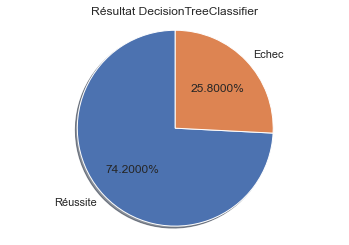

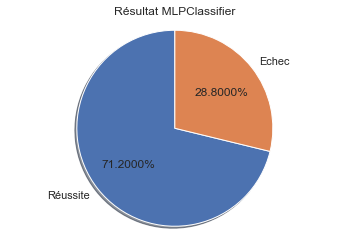

In [13]:
#Illustration des résultats sous forme graphique
labels = 'Réussite', 'Echec'
sizes = [cpt_reussite_dt,cpt_echec_dt]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.4f%%',shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Résultat DecisionTreeClassifier')
plt.show()

labels = 'Réussite', 'Echec'
sizes = [cpt_reussite_mlp,cpt_echec_mlp]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.4f%%',shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Résultat MLPClassifier')
plt.show()